# Project FitNut - Classification Modelling via Natural Language Processing

<img src = " ../image/cover.png" alt = "cover"/>

([*Source*](https://surgesr.com/wp-content/uploads/2021/09/surge-new-logo.png))


# Contents  

## Part 1 (see Notebook 1)  

## Part 2  
### [Objective (Recap)](#recap)
### [Data Cleaning](#datacleaning)
### [EDA & Visualization](#edaviz)
- [Fitness](#fiteda)    
- [Nutrition](#nuteda)  

### [Modelling](#modelling)
- [Baseline](#baseline)    
- [Logistic Regression](#lr)  
- [KNeighborsClassifier (KNN)](#knn)    
- [Multinomial Naive Bayes](#mnb)    
- [Random Forest](#rf)

### [Model Evaluation](#modelevaluation)
### [Conclusion & Recommendation](#conrec)
- [Sentiment Analysis](#sentimentanalysis)  
- [Business Recommendations](#businessrecommendations)

---

<div id="recap"></div>

### Objective (Recap)

Develop a binary classification model to distinguish between posts from *bodyweightfitness* and *EatCheapAndHealthy* subreddits. 

---

In [1]:
# General Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Collectiong/Scraping Modules
import requests

#NLP Modules
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Modelling Modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, roc_curve, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report

%matplotlib inline


<div id="datacleaning"></div>

### Data Cleaning
The data cleaning procedure will involve the following steps:  
1) Drop duplicates  
2) Replace invalid inputs ([removed], [deleted]) with null values  
3) Fill missing values with empty strings  
4) Check title repetition in main body  
5) Create new 'text' column which will serve as the predictor feature  
6) Remove URLs from 'text' column  
7) Map 0/1 to bodyweightfitness and EatCheapAndHealthy subreddits respectively 


In [2]:
# Import combined scrapped dataframe
## fitnut_df = pd.read_csv('../data/fitnut_scrapped.csv')


In [3]:
fitnut_df.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      2000 non-null   object
 1   selftext   1581 non-null   object
 2   subreddit  2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


The non-null value count for 'selftext' decreased from 1994 before exporting to 1581 after importing; i.e. increase in null values by 413. This is because pd.read_csv reads empty strings ('') as null value rathar than an actual change in dataset. Hence, no issue to proceed as null values will be addressed shortly. 

In [4]:
fitnut_df.describe() # Summary statistics at a glance


,title,selftext,subreddit
count,2000,1581,2000
unique,1934,759,2
top,"God entered into my body, as a ghostly body, a...",[removed],bodyweightfitness
freq,5,800,1000


There are 1,934 unique posts out of 2,000 as seen from the number of unique titles in relation to the total title count, which translates to a healthy proportion of unique posts for modelling. The most repeated post (5 times) could possibly be a troll post based on the title. 

The figures for selftext are less promising. Out of a 1,581 non-null values for selftext, only 759 are unique in nature; the difference is largely due to the 800 'selftext' with [removed] values. Nonetheless, as a new 'text' column will be subsequently created which combine the 'title' and 'selftext' columns - coupled with the fact that it is not uncommon for reddit post titles to be sufficiently lengthy and descriptive - this will address the missing values for the 'selftext' column as the resultant 'text' will be populated with the values in the 'title' column. 

The returns for the 'subreddit' column are as expected: there are 2,000 counts which correspond to the total number of subreddit posts collected, split equally over the two unique values (bodyweightfitness and EatCheapAndHealthy). 


In [5]:
print(fitnut_df.duplicated().sum()) # Check for duplicate posts
print(fitnut_df.shape)


50
(2000, 3)


In [6]:
fitnut_df.drop_duplicates(keep = "first", inplace = True) # Drop duplicate posts to prevent data leakage
fitnut_df.shape


(1950, 3)

In [7]:
fitnut_df.isnull().sum() # Check for missing values
# 403 missing values identified in 'selftext' column


title          0
selftext     403
subreddit      0
dtype: int64

In [8]:
fitnut_df['selftext'].value_counts() # View value count for unique values in 'selftext' column
# Need to deal with [removed] and [deleted] values

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [9]:
# Check count for [removed] and [deleted] values in 'selftext' column
print(fitnut_df['selftext'].value_counts()[['[removed]']].sum())
print(fitnut_df['selftext'].value_counts()[['[deleted]']].sum())


766
6


In [10]:
# Replace all [removed] and [deleted] values with null 
fitnut_df = fitnut_df.replace({"[removed]": np.NaN, "[deleted]": np.NaN})


In [11]:
# Treatment for null values involves replacing with empty string (where applicable)
 # For ease of combining 'title' and 'selftext' columns subsequently
fitnut_df.fillna(value = "", inplace = True)


In [12]:
fitnut_df.isnull().sum() # All null values in dataframe addressed


title        0
selftext     0
subreddit    0
dtype: int64

In [13]:
# Check for repititions in 'selftext' column as some reddit users include the title in the main body
fitnut_df[fitnut_df['title'].isin(fitnut_df['selftext'])]


,title,selftext,subreddit
1759,I Made Delicious Noddle Soup from Leftover Turkey,I Made Delicious Noddle Soup from Leftover Turkey,EatCheapAndHealthy


As there is only a single post in which the user included the title in the main body, we will not take further action for data repetition as this single observation is unlikely to affect model results significantly. 

In [14]:
# Create new 'text' column by combining 'title' and 'selftext' columns
 # This will serve as the predictor variable used to predict which subreddit a given post originates from
fitnut_df['text'] = fitnut_df['title'] + fitnut_df['selftext'] 


In [15]:
# Remove URLs in the 'text' column via regex 
 # Retaining the URLs will distort the model as 'http' and 'www' etc. will be falsely identified as tokens for classification
fitnut_df['text'] = fitnut_df['text'].str.replace("http\S+|www.\S+", "", case = False, regex = True)


In [16]:
# Map 0/1 to bodyweightfitness and EatCheapAndHealthy subreddits respectively
 # This is solely to serve as unique identifiers and in no way ranking one over another (i.e. nutrition = positive, fitness = negative)
fitnut_df['subreddit'] = fitnut_df['subreddit'].map({'bodyweightfitness': 0, 'EatCheapAndHealthy': 1})


In [17]:
fitnut_df.head() # Data cleaning successful


,title,selftext,subreddit,text
0,Which door frame pull-up bar?,Hi I've never trained pull-ups before and now ...,0,Which door frame pull-up bar?Hi I've never tra...
1,Having trouble gaining weight,,0,Having trouble gaining weight
2,Pull-up negatives,,0,Pull-up negatives
3,How long to see Results?,,0,How long to see Results?
4,I don't have weights,,0,I don't have weights


In [18]:
# Save copy of combined cleaned dataframe
## fitnut_df.to_csv('../data/fitnut_cleaned.csv', index = False)


<div id="edaviz"></div>

### EDA & Visualization

For EDA, we analyze both bodyweightfitness and EatCheapAndHealthy subreddits separately. For each subreddit, we consider basic statistics, followed by unigram/bigram to note the potential key words/phrases in the corpus, before generating wordcloud for a larger-picture visualization. To enhance NLP, we incorporate CountVectorizer to the dataset, which is known to be relatively faster from a computational standpoint. Conversely, we reserve TfidVectorizer as a transformer to be included in the pipeline for model production, since it is known to be more accurate albeit more computationally demanding.  


<div id="fiteda"></div>

##### Fitness

In [18]:
print("Average number of words per post in bodyweightfitness: " + 
      str(round(fitnut_df.loc[fitnut_df['subreddit'] == 0]['text'].str.len().mean())))
print("Median number of words per post in bodyweightfitness: " + 
      str(round(fitnut_df.loc[fitnut_df['subreddit'] == 0]['text'].str.len().median())))
print("Number of words for shortest post in bodyweightfitness: " + 
      str(round(fitnut_df.loc[fitnut_df['subreddit'] == 0]['text'].str.len().min())))
print("Number of words for longest post in bodyweightfitness: " + 
      str(round(fitnut_df.loc[fitnut_df['subreddit'] == 0]['text'].str.len().max())))


Average number of words per post in bodyweightfitness: 409
Median number of words per post in bodyweightfitness: 54
Number of words for shortest post in bodyweightfitness: 0
Number of words for longest post in bodyweightfitness: 6008


Comparing the average number of words per post (409) to the median number of words per post (54) in the bodyweightfitness, it shows that the dataset is heavily influenced by the presence of univariate outliers, which accounts for the different between mean and median nuber of posts. Given that there are empty strings within the dataset, it is unsurprising that the the shortest post(s) have zero words. On the flipside, the longest post in bodyweightfitness has ~6,000 words, which is likely a comprehensive article on the subject topic. 


In [19]:
# Instantiate CountVectorizer for EDA
cvec = CountVectorizer(stop_words = 'english') # Set stopwords argument to adopt an English-based word list


In [20]:
# Isolate 'text' column only for fitness threads
fit_corpus = fitnut_df.loc[fitnut_df['subreddit'] == 0]['text'] 


In [21]:
# Parse fitness corpus into CountVectorizer and transform to fit into pd df
cvec.fit(fit_corpus)


CountVectorizer(stop_words='english')

In [22]:
fit_corpus = cvec.transform(fit_corpus)


In [23]:
fit_corpus_df = pd.DataFrame(fit_corpus.todense(), columns = cvec.get_feature_names())


/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:>

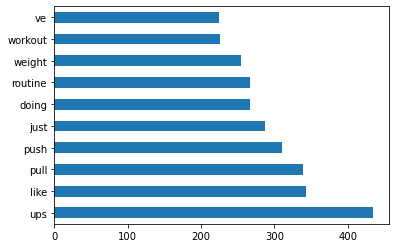

In [24]:
# Countvectorizer top words for fitness (unigram)
fit_corpus_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')


The most frequent word in the bodyweightfitness subreddit is "ups", which in itself does not hold much meaning as it possesses many forms; depending on the context, it may be an adverb, preposition, adjective and even noun. The other most frequent words - "like" and "push"/"pull" - is also ambiguous and its meaning not immediately apparent with respect to fitness. Perhaps for "push", its repetition might be due to the word being frequently used as a form of encouragement. The words "workout", "weight" and "routine" form the common words pertaining to fitness which we expect, as they are related to certain fitness regimes. As an example: 'this A routine consist B workout which involves a given sets/reps of C weights". 


<AxesSubplot:>

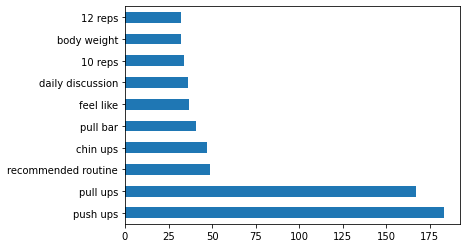

In [25]:
# Countvectorizer top words for fitness (bigram)
cvec = CountVectorizer(stop_words = 'english', ngram_range = (2, 2))
fit_corpus = fitnut_df.loc[fitnut_df['subreddit'] == 0]['text']
cvec.fit(fit_corpus)
fit_corpus = cvec.transform(fit_corpus)
fit_corpus_df = pd.DataFrame(fit_corpus.todense(), columns = cvec.get_feature_names())
fit_corpus_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')


Following on from above, certain words begin to make more sense when combined with adjacent words, the best examples being "pull ups" and "push ups", two unique exercises. As compared to their constituents, the invidiual words do not carry much meaning. While the majority of bigrams centre about discussions on workout routines, the bigram which caught my attention was "feel like", which was different from the other bigrams as it focusses on the emotional motiviations. Besides seeking for practical advice on fitness related matters, it appears that some users utilize the subreddit as a platform to air emotions, openly discuss feelings and seek validation on their arduous fitness journies. Generally, the bigrams for fitness posts are more meaningful. 

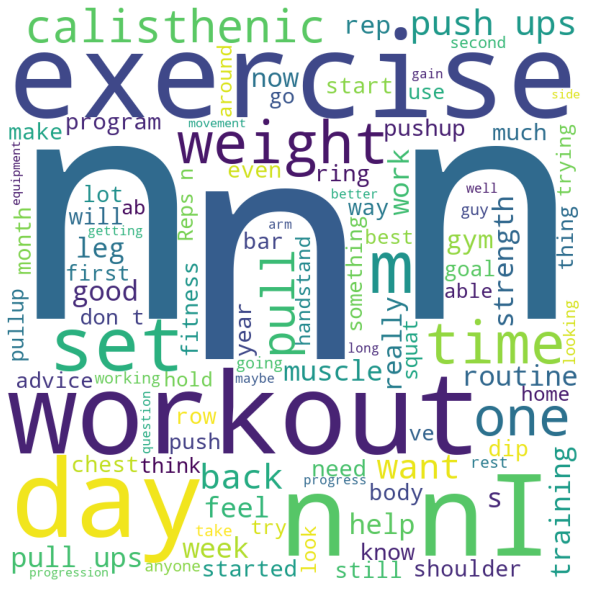

In [26]:
# Generate wordcloud for visualization
wordcloud = WordCloud(max_words= 100,
                      width = 800, height = 800,
                      background_color ='white',
                      stopwords = STOPWORDS,
                      min_font_size = 10).generate(str(pd.DataFrame(fitnut_df[(fitnut_df['subreddit'] == 0)].text).values))
 
plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
    

Apart from the fitness-centric unigrams/bigrams discussed above, the main observation from the wordcloud are the prevalence of time-related words: "time", "day", "week", "month", "year", "progression". This is accompanied by words in the present continuous tense: "pushing", "trying", "looking', "training". By inference, these key words elucidates the temporalities of fitness, which doubtless does not manifest in a single instance, but rather, is an accumulation of grit, effort and sacrifice expanded *over time* with a pre-defined end goal in mind. 

<div id="nuteda"></div>

##### Nutrition

In [27]:
print("Average number of words per post in EatCheapAndHealthy: " + 
      str(round(fitnut_df.loc[fitnut_df['subreddit'] == 1]['text'].str.len().mean())))
print("Median number of words per post in EatCheapAndHealthy: " + 
      str(round(fitnut_df.loc[fitnut_df['subreddit'] == 1]['text'].str.len().median())))
print("Number of words for shortest post in EatCheapAndHealthy: " + 
      str(round(fitnut_df.loc[fitnut_df['subreddit'] == 1]['text'].str.len().min())))
print("Number of words for longest post in EatCheapAndHealthy: " + 
      str(round(fitnut_df.loc[fitnut_df['subreddit'] == 1]['text'].str.len().max())))


Average number of words per post in EatCheapAndHealthy: 347
Median number of words per post in EatCheapAndHealthy: 123
Number of words for shortest post in EatCheapAndHealthy: 0
Number of words for longest post in EatCheapAndHealthy: 10155


For the EatCheapAndHealthy subreddit, the average number of words per post (347) does not deviate too significantly compared to the equivalent for bodyweightfitness, although the median number of words per post (123) is double. Importantly, this signals to the potential outliers. Surprisingly, the longest post in EatCheapAndHealthy exceeds the 10,000 words mark, about 50% more as compared to the longest post in bodyweightfitness. It might well be the case that a user is leveraging the forum to post expositions on the topic, as opposed to the more succinct commonplace posts and comments.  


In [28]:
# Instantiate CountVectorizer for EDA
cvec = CountVectorizer(stop_words = 'english')


In [29]:
# Isolate 'text' column only for nutrition threads
nut_corpus = fitnut_df.loc[fitnut_df['subreddit'] == 1]['text']


In [30]:
# Parse nutrition corpus into CountVectorizer and transform to fit into pd df
cvec.fit(nut_corpus)
nut_corpus = cvec.transform(nut_corpus)
nut_corpus_df = pd.DataFrame(nut_corpus.todense(), columns = cvec.get_feature_names())


<AxesSubplot:>

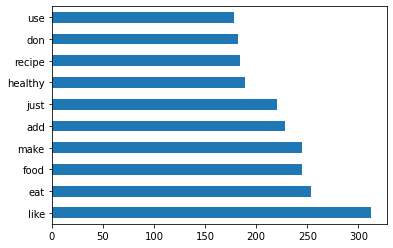

In [31]:
# Countvectorizer top words for nutrition (unigram)
nut_corpus_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')


A number of key words are as per expected: "eat", "food", "healthy", "recipe". These words are not only directly related to nutrition and the act of eating, but certain properties and arguments of it. 

<AxesSubplot:>

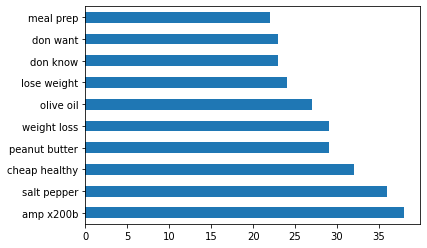

In [32]:
# Countvectorizer top words for nutrition (bigram)
cvec = CountVectorizer(stop_words = 'english', ngram_range = (2, 2))
nut_corpus = fitnut_df.loc[fitnut_df['subreddit'] == 1]['text']
cvec.fit(nut_corpus)
nut_corpus = cvec.transform(nut_corpus)
nut_corpus_df = pd.DataFrame(nut_corpus.todense(), columns = cvec.get_feature_names())
nut_corpus_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')


The top phrase "amp x200b" may be ignored as it is simply a character code used for zero-width space in reddit threads, with no bearing on the nutrition data collected. The other bigrams are largely aligned with the topic on healthy eating, as alluded to by the mention of "salt pepper", "olive oil" and "weight loss". A phrase which appeared out of place is "peanut butter", the fourth most repeated word, since it is not exactly associated with a healthy diet. In both cases, it is surprising that the words for both subreddits do not explicitly mention the words 'fitness' and 'nutrition' respectively, which one would naturally expect.                         


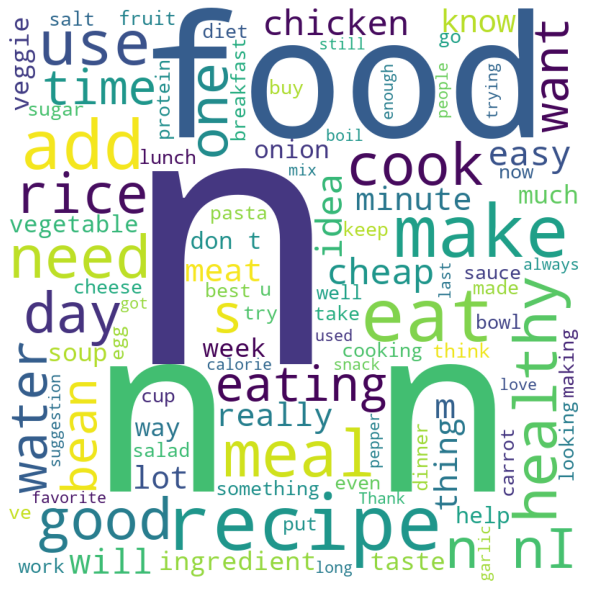

In [33]:
# word cloud for nutrition
wordcloud = WordCloud(max_words= 100,
                      width = 800, height = 800,
                      background_color ='white',
                      stopwords = STOPWORDS,
                      min_font_size = 10).generate(str(pd.DataFrame(fitnut_df[(fitnut_df['subreddit'] == 1)].text).values))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


Most of the frequently repeated words are already covered via the unigram/bigram analysis, with the main difference being the inclusion of ingredients: "fruit", "pasta", "meat", "cheese'. Admittedly, I expected to see more words/phrases related to the body (e.g. "lean", "shape") as it was supposed to be the parallel feature between fitness and nutrition, in that both maintain the same purpose of honing, training and conditioning the body.                                                                                                                                                                                                 

<div id="modelling"></div>

### Modelling

As stated under the Model Framework section in Part 1, four model types (Logistic Regression, KKNeighborsClassifier, Multinomial Naive Bayes and Random Forest) will be considered for the final binary classification model. The intention is to ensure the production modelling process is comprehensive by evaluating model types with varying mechanisms in ascertaining the optimal. For all models, the TfidfVectorizer will be applied to transform the words/texts into meaningful representations of numbers for computational processing and analysis. The TfidVectorizer is known to be more accurate than CountVectorizer albeit more computationally demanding. For all models, we keep the TfidVectorizer arguments (i.e. max features, stop words, ngram range) constant to maintain consistency between model comparisons:  
- Max features [500, 1000, 2500, 5000]: Limit the top tokens ordered by term frequency for comparison  
- Stop word [None, English]: Explore model without stop words vs model adopting an English-based word list although logically, the latter will produce better results as it removes common words which does not value-add in classification  
- Ngram range [(1, 1), (1, 2)]: Limit tokens to only unigrams and bigrams  
    
After performing train-test split, the modelling process involves the following steps:
1) Create pipeline with TfidVectorizer and a specific model type  
2) Incorporate parameters for model type into pipeline  
3) Set up gridsearch to optimize classifier by iterating through hyperparameters to identify the "best"  
4) Fit optimized classifer into the training set to train the model  
5) View highest performing estimators and parameters put through the pipelines  
6) Calculate score metrices for test dataset based on trained model  

For step (6), we define a custom function for scoring metrices:  


In [34]:
def metrices(model): # Argument = model type
    preds = model.predict(X_test) # Apply trained model to test set
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() # Create confusion matrix
    print("Train Accuracy Score: " + str(model.best_score_)) # Generate train accuracy score   
    print("Test Accuracy Score: " + str(accuracy_score(y_test, preds))) # Generate test accuracy score  
    print("F1 Score: " + str(f1_score(y_test, preds))) # Generate F1 score
    print("ROC AUC Score: " + str(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))) # Generate ROC AUC score
    plot_confusion_matrix(model, X_test, y_test, cmap = "Blues") # plot confusion matrix
    

<div id="baseline"></div>

##### Baseline

The cleaned data is split into training and test sets for modelling. Given that there is a fairly large number of observations (~2,000), a test size of 20% is assessed to be adequate. 

In [35]:
X = fitnut_df['text'] # Predictor variable
y = fitnut_df['subreddit'] # Target variable


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = y) # Preserve proportion of target variables in train and test datasets


In [37]:
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))


1    0.5
0    0.5
Name: subreddit, dtype: float64
1    0.5
0    0.5
Name: subreddit, dtype: float64


The baseline accuracy score is simply taken to be 50% , since we have a 1:1 ratio of bodyweightfitness posts to EatCheapAndHealthy posts. In other words, if one was to randomly assign a given post, there is an equal chance of either classifying it under the bodyweightfitness or EatCheapAndHealthy subreddit. 

<div id="lr"></div>

##### Logistic Regression

In [38]:
# (1) Instantiate logreg model and create pipeline
pipe_lr = Pipeline([
    ('tvec', TfidfVectorizer()), 
    ('lr', LogisticRegression(solver = 'saga')) # Saga solver selected it supports elasticnet to be passed 
])


In [39]:
# (2) Incorporate parameters for logreg pipeline
pipe_lr_params = {
    'tvec__max_features': [500, 1000, 2500, 5000], 
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)], 
    'lr__penalty': ['l1', 'l2', 'elasticnet'], # Consider ridge, lasso and elasticnet regularization
    'lr__C': [1.0, 0.5, 0.1] # Vary regularization strength
}


In [40]:
# (3) Set up grid search for logreg pipeline
gs_lr = GridSearchCV(pipe_lr, 
                     pipe_lr_params, 
                     cv = 5, 
                     verbose = 1)


In [41]:
# (4) Fit optimized logreg classifier into train set
gs_lr.fit(X_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/p

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'lr__C': [1.0, 0.5, 0.1],
                         'lr__penalty': ['l1', 'l2', 'elasticnet'],
                         'tvec__max_features': [500, 1000, 2500, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [42]:
# (5a) View best estimator for logreg classifier based on gridsearch
gs_lr.best_estimator_


Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=2500, stop_words='english')),
                ('lr', LogisticRegression(solver='saga'))])

In [43]:
# (5b) View best parameters for logreg classifier based on gridsearch
gs_lr.best_params_


{'lr__C': 1.0,
 'lr__penalty': 'l2',
 'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

Train Accuracy Score: 0.9294871794871795
Test Accuracy Score: 0.9230769230769231
F1 Score: 0.9246231155778895
ROC AUC Score: 0.9737541091387245


/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


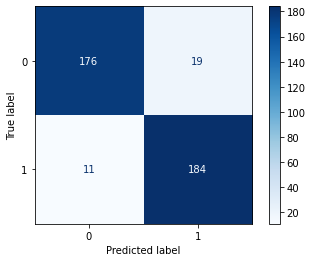

In [44]:
# (6) Compute scoring metrices for test set
metrices(gs_lr)


<div id="knn"></div>

##### KNeighborsClassifier (KNN)

In [45]:
# (1) Instantiate KNN model and create pipeline
pipe_knn = Pipeline([
    ('tvec', TfidfVectorizer()), 
    ('knn', KNeighborsClassifier())
])


In [46]:
# (2) Incorporate parameters for KNN pipeline
pipe_knn_params = {
    'tvec__max_features': [500, 1000, 2500, 5000], 
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)], 
    'knn__p': [1, 2], # Test euclidean distance vs manhattan distance between datapoints
    'knn__weights': ['uniform', 'distance'], # Assign equal weightage to all datapoints vs "nearer" neighbours having greater influence
    'knn__n_neighbors': [3, 5, 15] # Vary number of neighbours above, below and at default (=5), limited to odd numbers
}


In [47]:
# (3) Set up grid search for KNN pipeline
gs_knn = GridSearchCV(pipe_knn, 
                      pipe_knn_params, 
                      cv = 5, 
                      verbose = 1)


In [48]:
# (4) Fit optimized KNN classifier into train set
gs_knn.fit(X_train, y_train)


Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 15], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance'],
                         'tvec__max_features': [500, 1000, 2500, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [49]:
# (5a) View best estimator for KNN classifier based on gridsearch
gs_knn.best_estimator_


Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('knn', KNeighborsClassifier(n_neighbors=15))])

In [50]:
# (5b) View best parameters for KNN classifier based on gridsearch
gs_knn.best_params_


{'knn__n_neighbors': 15,
 'knn__p': 2,
 'knn__weights': 'uniform',
 'tvec__max_features': 5000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

Train Accuracy Score: 0.7935897435897437
Test Accuracy Score: 0.5333333333333333
F1 Score: 0.6818181818181819
ROC AUC Score: 0.6645101906640368


/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


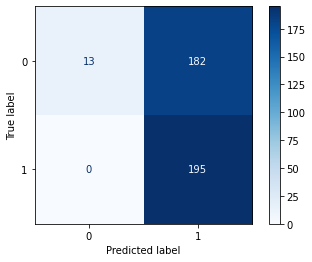

In [51]:
# (6) Compute scoring metrices for test set
metrices(gs_knn)


<div id="mnb"></div>

##### Multinomial Naive Bayes

In [52]:
# (1) Instantiate MNB model and create pipeline
pipe_mnb = Pipeline([
    ('tvec', TfidfVectorizer()), 
    ('mnb', MultinomialNB())
])


In [53]:
# (2) Incorporate parameters for MNB pipeline
pipe_mnb_params = {
    'tvec__max_features': [500, 1000, 2500, 5000], 
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)], 
    'mnb__alpha': [1, 0], # Adapt the model to respond to tokens not found in the train set
    'mnb__fit_prior': [True, False], # Learn class prior probabilities
}


In [54]:
# (3) Set up grid search for MNB pipeline
gs_mnb = GridSearchCV(pipe_mnb, 
                      pipe_mnb_params, 
                      cv = 5, 
                      verbose = 1)


In [55]:
# (4) Fit optimized MNB classifier into train set
gs_mnb.fit(X_train, y_train)


Fitting 5 folds for each of 64 candidates, totalling 320 fits


/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'mnb__alpha': [1, 0], 'mnb__fit_prior': [True, False],
                         'tvec__max_features': [500, 1000, 2500, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [56]:
# (5a) View best estimator for MNB classifier based on gridsearch
gs_mnb.best_estimator_


Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('mnb', MultinomialNB(alpha=1))])

In [57]:
# (5b) View best parameters for MNB classifier based on gridsearch
gs_mnb.best_params_


{'mnb__alpha': 1,
 'mnb__fit_prior': True,
 'tvec__max_features': 5000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

Train Accuracy Score: 0.9243589743589744
Test Accuracy Score: 0.9076923076923077
F1 Score: 0.9057591623036648
ROC AUC Score: 0.9803944773175542


/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


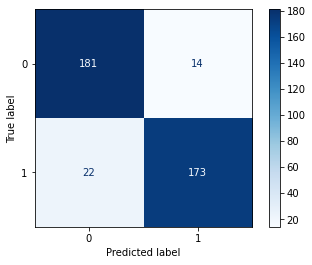

In [58]:
# (6) Compute scoring metrices for test set
metrices(gs_mnb)


<div id="rf"></div>

##### Random Forest

In [59]:
# (1) Instantiate Random Forest model and create pipeline
pipe_rf = Pipeline([
    ('tvec', TfidfVectorizer()), 
    ('rf', RandomForestClassifier())
])


In [60]:
# (2) Incorporate parameters for Random Forest pipeline
pipe_rf_params = {
    'tvec__max_features': [500, 1000, 2500, 5000], 
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)], 
    'rf__n_estimators': [50, 100, 200], # Vary number of trees in forest 
    'rf__max_features': [None, 'auto'], # Set max features
    'rf__random_state': [42] # Control randomness as bootstrapping = true 
}


In [61]:
# (3) Set up grid search for Random Forest pipeline
gs_rf = GridSearchCV(pipe_rf, 
                     pipe_rf_params, 
                     cv = 5, 
                     verbose = 1,
                     n_jobs = -1)


In [62]:
# (4) Fit optimized Random Forest classifier into train set
gs_rf.fit(X_train, y_train)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_features': [None, 'auto'],
                         'rf__n_estimators': [50, 100, 200],
                         'rf__random_state': [42],
                         'tvec__max_features': [500, 1000, 2500, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [66]:
# (5a) View best estimator for Random Forest classifier based on gridsearch
gs_rf.best_estimator_


Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('rf',
                 RandomForestClassifier(n_estimators=50, random_state=42))])

In [67]:
# (5a) View best estimator for Random Forest classifier based on gridsearch
gs_rf.best_params_


{'rf__max_features': 'auto',
 'rf__n_estimators': 50,
 'rf__random_state': 42,
 'tvec__max_features': 5000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

Train Accuracy Score: 0.8961538461538462
Test Accuracy Score: 0.9
F1 Score: 0.9051094890510949
ROC AUC Score: 0.9665351742274819


/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


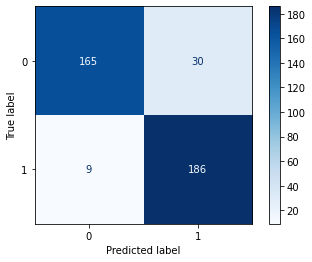

In [68]:
# (6) Compute scoring metrices for test set
metrices(gs_rf)


Next, we consolidate the scores and evaluate model performance. 

<div id="modelevaluation"></div>

### Model Evaluation

||Train Accuracy Score|Test Accuracy Score|F1 Score|ROC AUC Score|
|---|---|---|---|---|
|Logistic Regression|0.9301|0.9231|0.9246|0.9738|
|KNeighborsClassifier|0.7936|0.5333|0.6818|0.6645|
|Multinomial Naive Bayes|0.9244|0.9077|0.9058|0.9804|
|Random Forest|0.8962|0.9000|0.9051|0.9665|


Comparing the scoring metrices, the three probabilistic models (Logistic Regression, Multinomial Naive Bayes, Random Forest) had similar performances with accuracy, F1 and ROC AUC scores at 90% or above, which would meet the 90% benchmark set under model framework. In contrast, the KNeighborsClassifier model paled in comparison significantly, with scores in the range of 50% to 70%. This shows that building the binary classification model using distance logic for prediction is not advisable, likely due to a weak spatial relationship between observations. The large difference between the train accuracy score (80%) and test accuracy score (~50%) translates to the KNeighborsClassifier model being severely overfitted. 

Of the three remaining models, we will drop the Random Forest model as it performs relatively poorer across the spectrum of scores, albeit only marginally. Between the Logistic Regression model and the Multinomial Naive Bayes model, **we will select the Logistic Regression model as the final production model since it returns the highest scores for accuracy and F1 score, and the ROC AUC score is only slightly lower (<1% difference)**. Further, the difference between the test accuary and train accuracy scores for the latter (~2%) is noticeably higher than that of the latter (<1%), which signals to the Multinomial Naive Bayes model sufferring from a greater degree of overfitting. In sum, the production model has the following parameters: 
- *Model type: Logistic Regression*
- Max number of features: 2,500
- Stop words used: English
- Best NGram: Unigram
- LogReg Penalty: Ridge
- LogReg Penalty Strength: Minimal

Based on the test accuracy score for the production model, the model will be able to classify a given post correctly ~92% of the time. The high F1-score of ~92% illustrates an optimal equilibrium achieved in the precision-recall tradeoff; the model not only achieves a high percentage in determining the number of true positives over the total positives in the dataset, but with high confidence as well. Lastly, the high ROC AUC score of ~97% indicates that the model effectively minimizes false positives and false negatives, and has strong ability to distinguish between both binary classes (i.e. bodyweightfitness and EatCheapAndHealthy subreddits). 


In [69]:
# Generate prediction probabilities for ROC curve
fpr_lr, tpr_lr, thresh_lr = roc_curve(y_test, gs_lr.predict_proba(X_test)[:, 1])
fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, gs_knn.predict_proba(X_test)[:, 1])
fpr_mnb, tpr_mnb, thresh_mnb = roc_curve(y_test, gs_mnb.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, gs_rf.predict_proba(X_test)[:, 1])


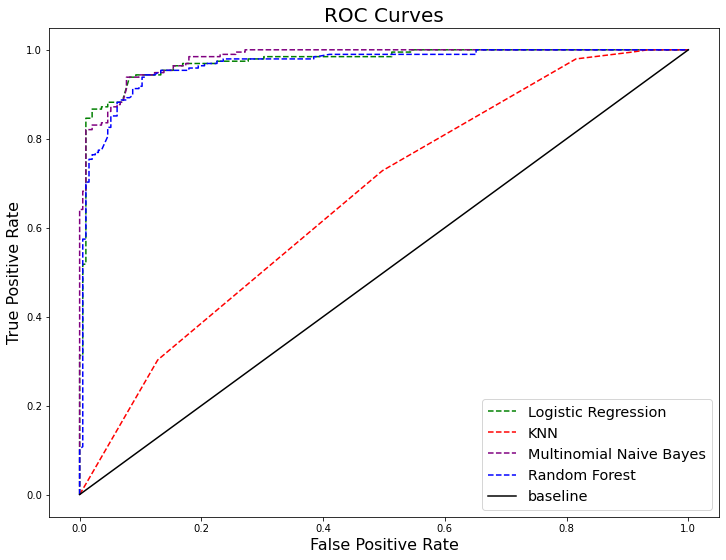

In [70]:
# Plot ROC curves
plt.figure(figsize = (12, 9))

plt.plot(fpr_lr, tpr_lr, linestyle = '--', color = 'green', label = 'Logistic Regression')
plt.plot(fpr_knn, tpr_knn, linestyle = '--', color = 'red', label = 'KNN')
plt.plot(fpr_mnb, tpr_mnb, linestyle = '--', color = 'purple', label = 'Multinomial Naive Bayes')
plt.plot(fpr_rf, tpr_rf, linestyle = '--', color = 'blue', label = 'Random Forest')
plt.plot([0, 1], [0, 1], linestyle = '-', color = 'black', label = 'baseline')

plt.title('ROC Curves', size = 20)

plt.xlabel('False Positive Rate', size = 16)
plt.ylabel('True Positive Rate', size = 16)

plt.legend(loc = 'lower right', fontsize = 'x-large')

plt.show()


The ROC curves corroborate the results above, in which the KNeighborsClassifier model is by far the worst performing model, while the other models have similar performances although the Logistic Regression model edges out slightly. The large area under the curve (measured by ROC AUC score) is a reflection of the model's high class separation capacity and the close-to-right-angled graph shows that for a given unit change in threshold, false values are effectively minimized accordingly. 

In [71]:
# Feature importance
tfidf = TfidfVectorizer() # Instantiate TfidfVectorizer
X_train_vect = tfidf.fit_transform(X_train) # Fit transform train set into TfidfVectorizer
features = tfidf.get_feature_names() # Store important feature names


/Users/Nicholas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [72]:
lr = LogisticRegression(solver = 'saga') # Instantiate Logistic Regression
lr.fit(X_train_vect, y_train) # Fit vectorized X train set and y train set into Logistic Regression model
coef = lr.coef_[0].tolist() # Store coefficients for important features


In [73]:
features_coef = pd.DataFrame() # Initialize empty df
features_coef['features'] = pd.Series(features) # First column = important feature names
features_coef['coefficients'] = coef # Second column = coefficients for important features


In [74]:
features_coef = features_coef.sort_values('coefficients', ascending = False) # Sort by largest coefficient values for important features
features_coef # Print important features


,features,coefficients
3070,food,2.532891
5849,recipe,2.528943
2545,eat,2.031133
1601,chicken,1.847363
4496,meals,1.839361
...,...,...
2762,exercises,-2.204722
6137,routine,-2.235346
7656,ups,-2.353819
5665,pull,-2.552621


The table above lists the key features which the production model classifies a given post by. While we are not able to directly translate the coefficient value into its material effect, the coefficient magnitude is a reflection of degree of a feature's strength in influencing the classification. On both ends of the spectrum, we note the main tokens used by the production model to classify fitness and nutrition posts respectively. 


<div id="conrec"></div>

### Conclusion & Recommendation

In conclusion, the study has achieved its primary objective of developing a binary classification model to distinguish between posts from bodyweightfitness and EatCheapAndHealthy subreddits, at the established scoring benchmark of 90%. The high scores obtained may also in part be attributed to the nature of the texts; the words in the posts for the respective subreddit posts are more differentiated than initially projected.  

To further improve, a more diverse range of model types may be trained/tested, and (hyper)parameters further tuned. Additionally, related subreddits may also be considered to provide extra training data for the model, which would likely enhance classification results. 


<div id="sentimentanalysis"></div>

##### Sentiment Analysis

As an added complimentary service, we conduct sentiment analysis to comprehend the qualitative aspects of both subreddits, which could inform business recommendations alongside classification too. 

In [75]:
# Instantiate sentiment analyzer
sent = SentimentIntensityAnalyzer()


In [76]:
# Consolidate values in 'Text' column for fitness posts into a single cell
fit_text = fitnut_df.loc[fitnut_df['subreddit'] == 0]['text'].str.cat(sep = ', ')


In [77]:
# Successfully consolidated into a single cell
fit_text

'Which door frame pull-up bar?Hi I\'ve never trained pull-ups before and now I want some lats so I\'m buying a door-frame pull-up bar. There are two pull-up bars on eBay that I saw, one of them only has a few grips available but the other one has 12 grip options with angled grips and stuff. They\'re both about the same price so I\'m wondering which one I should buy because obviously the 12grip one has more variety but I thought the amount of bars it has might affects the material\'s stability. The few grips one also has much more buyers and just more popular. (sorry I don\'t know all the terminologies)\n\nLinks\n\n12grip:[\n\nfew grip:[, Having trouble gaining weight, Pull-up negatives, How long to see Results?, I don\'t have weights, Upper back strengthening, Question about calisthenics skills periodizationFirst of all,I\'m sorry for my bad english\nSo,I\'ve been training calisthenics for about 1,5 year, and now I can do Front Lever,Straddle planche and those things.But since Septembe

In [78]:
# Sentiment analysis score for fitness posts
sent.polarity_scores(fit_text)


{'neg': 0.065, 'neu': 0.795, 'pos': 0.14, 'compound': 1.0}

In [79]:
# Consolidate values in 'Text' column for nutrition posts into a single cell
nut_text = fitnut_df.loc[fitnut_df['subreddit'] == 1]['text'].str.cat(sep = ', ')


In [80]:
# Successfully consolidated into a single cell
nut_text


'The Smoothie Diet: 21 Day Rapid Weight Loss ProgramThis smoothie diet 21 day rapid weight loss program is meant for those who want to start dieting and weight loss and is carefully produced so that you can even use it everyday even after the program ends! This 3 week program is made so that all you have to do is replace certain meals with the smoothie recipes provided and then watch as the pounds melt effortlessly off your body and your energy levels skyrocket. \n\nLink in bio to find out more information on it, thank you!, Full Guide About Tosh Trek, Colorado alternative to AldiI moved to CO a few years ago, and I still haven’t found somewhere as cheap as Aldi that also carries a decent gluten free selection 😭 Does anyone have any recommendations? \n\nI’m in Denver, if that helps!, HOW TO LOSE WEIGHT TIPS AND TRICKS, This weeks theme ingredient is... Pumpkin! What do we make?Our next key ingredient is **Pumpkin!** Let us know how you can add it to a dish to make it even better or how

In [81]:
# Sentiment analysis score for nutrition posts
sent.polarity_scores(nut_text)


{'neg': 0.053, 'neu': 0.802, 'pos': 0.145, 'compound': 1.0}

For both bodyweightfitness and EatCheapAndHealthy reddit posts, the sentiment analysis is quite similar and fairly positive. About 14-15% of the total text is read as positive, which is more than double that of negative text at about 5-6%. Neutral text forms the majority, accounting for 80% of total text. More commendably, the compound score (normalized score (-1 to 1) based on the sum of negative, neutral and positive scores) for both is 1.0, indicating a high level of positivity. This is not unsurprising as discussions for both subreddits mainly revolve around individuals seeking improvement in a particular aspect of his/her life, where most other users respond with practical advice and/or words of encouragement. 


<div id="businessrecommendations"></div>

##### Business Recommendations

Returning to the initial problem statement, SURGE may confidently adopt the chosen production model for the fitness and nutrition teams to predict parent subreddits, where the teams handling the portfolios may assess the posts subsequently. On a closing note, it is also promising to note that the sentiments for both forums are generally positive, and conclusions drawn from the posts will likely be indicative of prevailing and upcoming trends for both domains. 
